In [1]:
import pandas as pd
from scipy import stats
import itertools

In [2]:
import os
import sys
sys.path.append(os.path.join("..",".."))
from discotec import *

In [3]:
from scipy.optimize import linear_sum_assignment
import seaborn as sns

import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

# Generating partitions

In [4]:
@partial(jax.jit, static_argnums=[1, 2])
def generate_reference_partition(random_key, n_samples, n_clusters):
    y_true = jax.random.choice(random_key, n_clusters, shape=(n_samples,))
    return y_true

In [5]:
@partial(jax.vmap, in_axes=[0,None,0,None])
@partial(jax.jit, static_argnums=[3])
def generate_fixedK_partition(key, reference, conservation_prob, n_clusters):
    relabelling_key, new_cluster_key = jax.random.split(key, 2)
    to_conserve = jax.random.bernoulli(relabelling_key, p=conservation_prob, shape=reference.shape)
    # To keep the accuracy between expected bounds, we make sure that
    # new_clusters is always different from the reference partition
    new_clusters = jax.random.choice(new_cluster_key, n_clusters-1, shape=reference.shape)
    new_clusters = (new_clusters+reference+1)%n_clusters
    

    return reference*to_conserve+new_clusters*(1-to_conserve)


In [6]:
@partial(jax.jit, static_argnums=[1,2,3,4])
def generate_scenario(random_key, n_samples, n_models, n_clusters, n_ref_1):
    reference_key, subref_key, models_key = jax.random.split(random_key, 3)

    # We start by generate the labels of this scenario and all similar centroids
    y_true = generate_reference_partition(reference_key, n_samples, n_clusters)

    centroids = generate_fixedK_partition(jax.random.split(subref_key,num=2), y_true, jnp.array([0.2, 0.9]), n_clusters)
    centroid_1, centroid_2 = centroids

    models_key_1, models_key_2 = jax.random.split(models_key, num=2)
    probs_1 = jax.random.uniform(models_key_1, shape=(n_ref_1,))
    probs_2 = jax.random.uniform(models_key_2, shape=(n_models-n_ref_1))
    
    y_pred_1 = generate_fixedK_partition(jax.random.split(models_key_1, num=n_ref_1), centroid_1, probs_1, n_clusters).reshape((-1, n_samples))
    y_pred_2 =  generate_fixedK_partition(jax.random.split(models_key_2, num=n_models-n_ref_1), centroid_2, probs_2, n_clusters).reshape((-1, n_samples))

    return y_true, jnp.concatenate([y_pred_1, y_pred_2], axis=0)

In [7]:
def unsupervised_accuracy(y_true,y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    r, c = linear_sum_assignment(confusion_matrix, maximize=True)

    return confusion_matrix[r,c].sum()/confusion_matrix.sum()

# Run the simulations

In [8]:
n_samples = 200
n_models = 50
n_runs = 50
n_clusters = 10
n_subrefs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
filename =  f"hierarchical_results_{n_models}.csv"
print(n_subrefs)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [9]:
master_key = jax.random.key(0)
all_correlations = []
all_selected_aris = []
for n_subref in n_subrefs:
    print(n_subref)
    if os.path.exists(filename):
        continue
    for i in range(n_runs):
        print(i, end=" ")
        # Split the random key
        master_key, dataset_key = jax.random.split(master_key)
    
        # Generate the scenario
        y_true, y_pred = generate_scenario(dataset_key, n_samples, n_models, n_clusters, int(jnp.ceil(n_subref*n_models).item()))
    
        # Compute the consensus matrix
        centroid = compute_consensus_matrix(y_pred)
    
        # Evaluate all metrics
        ## External validity index
        true_aris = jnp.array([metrics.adjusted_rand_score(y_true, y) for y in y_pred])
    
        # Connectivity based index
        ## Notice that we negate to get a metric to maximise (instead of minimising)
        tv_ranking_scores = -compute_tv_ranking(y_pred, centroid)
        hellinger_ranking_scores = -compute_hellinger_ranking(y_pred, centroid)
        kl_ranking_scores = -compute_kl_ranking(y_pred, centroid)

        quantised_centroid = (centroid>centroid.mean()).astype(float)
        quantised_scores = -compute_tv_ranking(y_pred, quantised_centroid)
        
        pairwise_ari_scores = pairwise_score(y_pred)
        pairwise_nmi_scores = pairwise_score(y_pred, method="nmi")
    
        for name, scores in zip(["DISCO_TV","DISCO_KL","DISCO_H","AARI","ANMI", "DISCO_Q"],
                                [tv_ranking_scores, kl_ranking_scores, hellinger_ranking_scores,
                                pairwise_ari_scores, pairwise_nmi_scores, quantised_scores]):
            for corr_name, corr_fct in zip(["Pearson", "Spearman", "Kendall"], [stats.pearsonr, stats.spearmanr, stats.kendalltau]):
                all_correlations += [{
                    "Score":name,
                    "Correlation":corr_name,
                    "Value":corr_fct(true_aris, scores).statistic,
                    "Run":i,
                    "Mix":n_subref
                }]
            
            all_selected_aris += [{
                "Score":name,
                "ARI":true_aris[jnp.argmax(scores)].item(),
                "Best_ARI":max(true_aris),
                "Run":i,
                "Mix":n_subref
                
            }]
if not os.path.exists(filename):
    df = pd.DataFrame(all_correlations)
    df.to_csv(filename)
    df = pd.DataFrame(all_selected_aris)
    df.to_csv(filename.replace(".csv","_aris.csv"))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


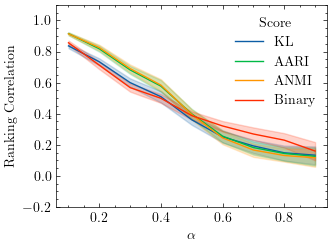

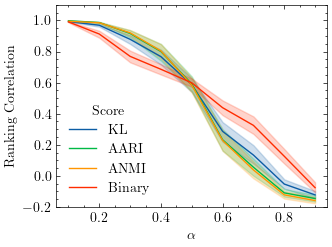

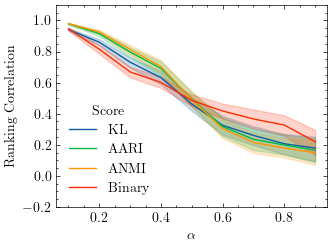

In [10]:
df = pd.read_csv(f"hierarchical_results_50.csv")
# For the storytelling purposes, I dropped the weighted scores
filtered_df = df[~df.Score.isin(["DISCO_TV", "DISCO_H"])].replace({"DISCO_TV":"Total variation", "DISCO_H":"Hellinger", "DISCO_Q":"Binary", "DISCO_KL":"KL"})

for correlation, subdf in filtered_df.groupby("Correlation"):
    axes = sns.lineplot(subdf, x="Mix", y="Value", hue="Score")
    plt.ylim((-0.2,1.1))
    plt.ylabel("Ranking Correlation")
    plt.xlabel(r"$\alpha$")
    plt.savefig(f"{correlation}_{n_models}.pdf", bbox_inches="tight")
    plt.show()

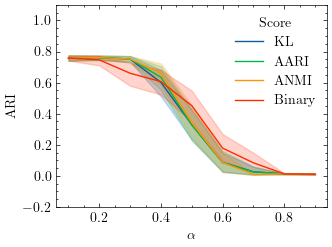

In [11]:
df = pd.read_csv(f"hierarchical_results_50_aris.csv")
# For the storytelling purposes, I dropped the weighted scores
filtered_df = df[~df.Score.isin(["DISCO_TV", "DISCO_H"])].replace({"DISCO_TV":"Total variation", "DISCO_H":"Hellinger", "DISCO_Q":"Binary", "DISCO_KL":"KL"})

sns.lineplot(filtered_df, x="Mix", y="ARI", hue="Score")
plt.ylim((-0.2,1.1))
plt.ylabel("ARI")
plt.xlabel(r"$\alpha$")
plt.savefig(f"ARI_{n_models}.pdf", bbox_inches="tight")
plt.show()

0.7159789141343336
Best available ARI was: 0.7159789141343336
-0.0016588538589142605
Best available ARI was: 0.6908625225750659
-0.003660457297733373
Best available ARI was: 0.4966642330959084


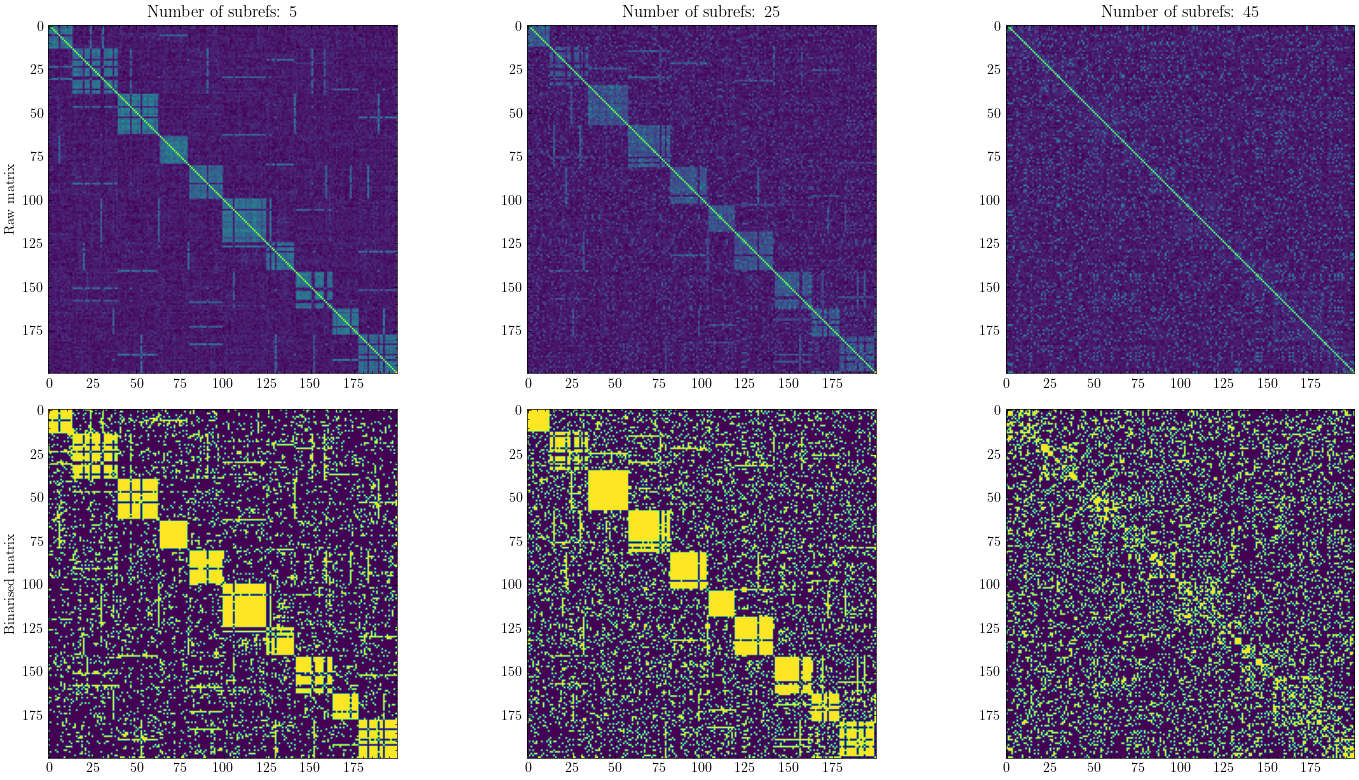

In [12]:
# Let us save as well some figures of the consensus matrices
master_key = jax.random.key(0)
plt.figure(figsize=(15,8))
for i, rho in enumerate([5,25,45]):
    plt.subplot(2,3,i+1)
    # Split the random key
    master_key, dataset_key = jax.random.split(master_key)

    # Generate the scenario
    y_true, y_pred = generate_scenario(dataset_key, n_samples, 50, n_clusters, rho)
    
    # Compute the consensus matrix
    centroid = compute_consensus_matrix(y_pred)

    # Compute the quantised score
    quantised_centroid = (centroid>centroid.mean()).astype(float)

    quantised_score = compute_tv_ranking(y_pred, quantised_centroid)
    best_model = jnp.argmin(quantised_score)
    order = jnp.argsort(y_true)

    print(metrics.adjusted_rand_score(y_true, y_pred[best_model]))
    print("Best available ARI was:", max([metrics.adjusted_rand_score(y_true,y) for y in y_pred]))
    

    plt.imshow(centroid[order][:,order])
    plt.title(f"Number of subrefs: {rho}")

    if i==0:
        plt.ylabel("Raw matrix")

    plt.subplot(2,3,i+4)


    plt.imshow(quantised_centroid[order][:,order])
    if i==0:
        plt.ylabel("Binarised matrix")
plt.tight_layout()
plt.savefig("example_selection.pdf", bbox_inches="tight")
plt.show()

0.7159789141343336
Best available ARI was: 0.7159789141343336
-0.0016588538589142605
Best available ARI was: 0.6908625225750659
-0.003660457297733373
Best available ARI was: 0.4966642330959084


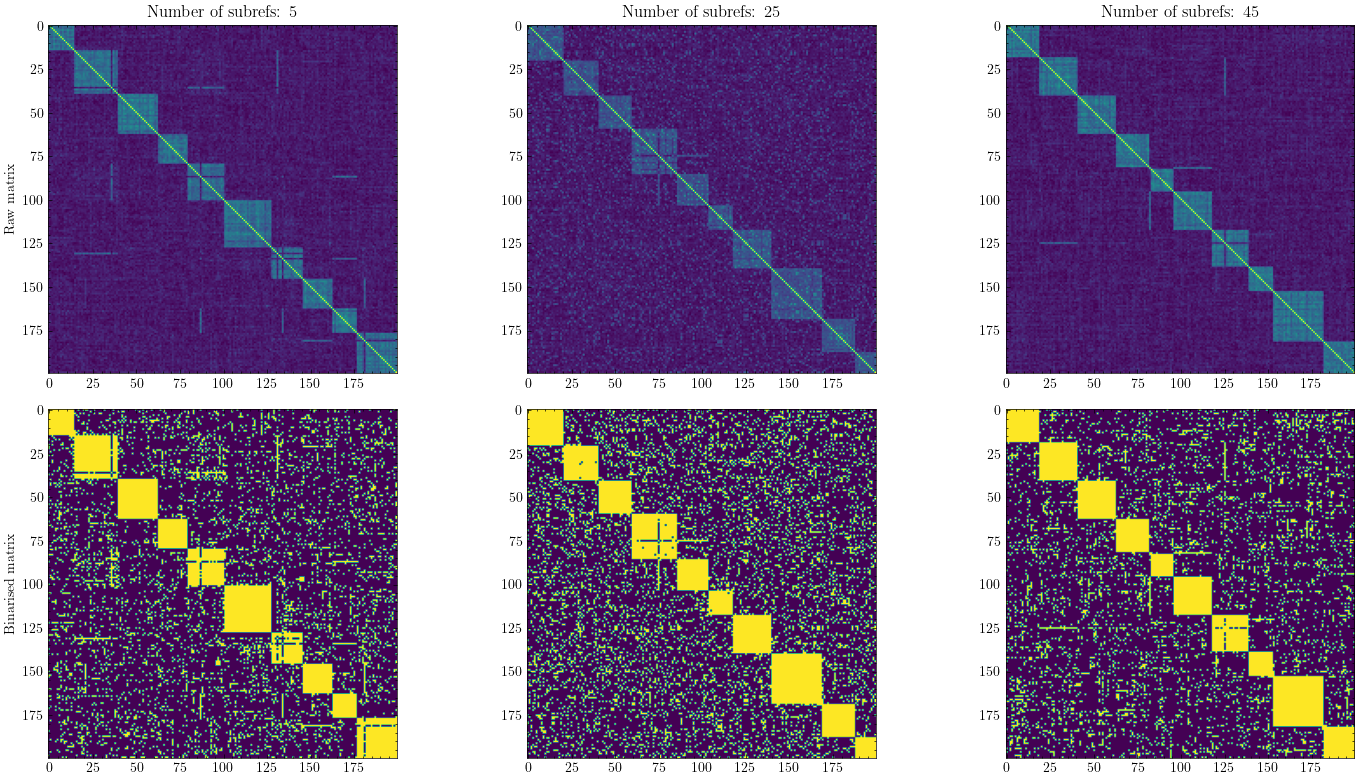

In [13]:
# Let us save as well some figures of the consensus matrices
master_key = jax.random.key(0)
plt.figure(figsize=(15,8))
for i, rho in enumerate([5,25,45]):
    plt.subplot(2,3,i+1)
    # Split the random key
    master_key, dataset_key = jax.random.split(master_key)

    # Generate the scenario
    y_true, y_pred = generate_scenario(dataset_key, n_samples, 50, n_clusters, rho)
    order = jnp.argsort(y_true)
    
    # Compute the consensus matrix
    centroid = compute_consensus_matrix(y_pred)

    # Compute the quantised score
    quantised_centroid = (centroid>centroid.mean()).astype(float)

    quantised_score = compute_tv_ranking(y_pred, quantised_centroid)
    best_model = jnp.argmin(quantised_score)
    order = jnp.argsort(y_pred[best_model])

    print(metrics.adjusted_rand_score(y_true, y_pred[best_model]))
    print("Best available ARI was:", max([metrics.adjusted_rand_score(y_true,y) for y in y_pred]))
    

    plt.imshow(centroid[order][:,order])
    plt.title(f"Number of subrefs: {rho}")

    if i==0:
        plt.ylabel("Raw matrix")

    plt.subplot(2,3,i+4)


    plt.imshow(quantised_centroid[order][:,order])
    if i==0:
        plt.ylabel("Binarised matrix")
plt.tight_layout()
plt.savefig("example_selection.pdf", bbox_inches="tight")
plt.show()

In [14]:
@partial(jax.jit, static_argnums=[1,2,3,4])
def generate_scenario(random_key, n_samples, n_models, n_clusters, n_ref_1):
    reference_key, subref_key, models_key = jax.random.split(random_key, 3)

    # We start by generate the labels of this scenario and all similar centroids
    y_true = generate_reference_partition(reference_key, n_samples, n_clusters)

    centroids = generate_fixedK_partition(jax.random.split(subref_key,num=2), y_true, jnp.array([0.2, 0.9]), n_clusters)
    centroid_1, centroid_2 = centroids

    models_key_1, models_key_2 = jax.random.split(models_key, num=2)
    probs_1 = jax.random.uniform(models_key_1, shape=(n_ref_1,))
    probs_2 = jax.random.uniform(models_key_2, shape=(n_models-n_ref_1))
    
    y_pred_1 = generate_fixedK_partition(jax.random.split(models_key_1, num=n_ref_1), centroid_1, probs_1, n_clusters).reshape((-1, n_samples))
    y_pred_2 =  generate_fixedK_partition(jax.random.split(models_key_2, num=n_models-n_ref_1), centroid_2, probs_2, n_clusters).reshape((-1, n_samples))

    return y_true, centroids, jnp.concatenate([y_pred_1, y_pred_2], axis=0)

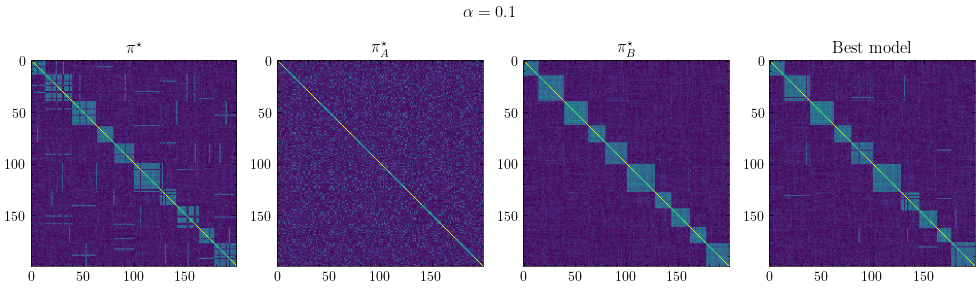

Best available ARI was: 0.7159789141343336
ARI of selected model with ground truth 0.7159789141343336
ARI with C1:  0.0008462740510066032
ARI with C2:  0.9470825072786702


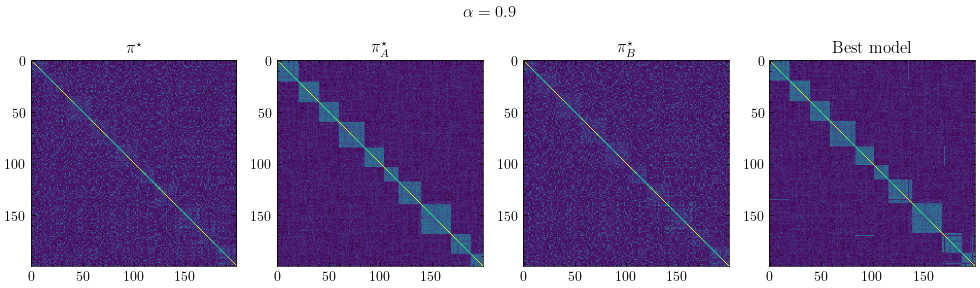

Best available ARI was: 0.6246149537468658
ARI of selected model with ground truth -0.0038532750447127064
ARI with C1:  0.9700497323274956
ARI with C2:  -0.004585522974054076


In [24]:
# Let us save as well some figures of the consensus matrices
master_key = jax.random.key(0)
for rho in [5,45]:
    
    # Split the random key
    master_key, dataset_key = jax.random.split(master_key)

    # Generate the scenario
    y_true, centroids, y_pred = generate_scenario(dataset_key, n_samples, 50, n_clusters, rho)
    
    # Compute the consensus matrix
    centroid = compute_consensus_matrix(y_pred)

    # Compute the quantised score
    quantised_centroid = (centroid>centroid.mean()).astype(float)

    quantised_score = compute_tv_ranking(y_pred, quantised_centroid)
    best_model = jnp.argmin(quantised_score)


    plt.figure(figsize=(10,3))
    for i, (name, y) in enumerate(zip([r"$\pi^\star$", r"$\pi^\star_A$", r"$\pi^\star_B$", "Best model"], [y_true, centroids[0], centroids[1], y_pred[best_model]])):
        plt.subplot(1,4,i+1)
        order = jnp.argsort(y)
        plt.imshow(centroid[order][:,order])
        plt.title(name)

    plt.suptitle(fr"$\alpha =  {rho/50:.1f}$")
    plt.tight_layout()
    plt.savefig(f"example_selection_{rho}.pdf", bbox_inches="tight")
    plt.show()
    print("Best available ARI was:", max([metrics.adjusted_rand_score(y_true,y) for y in y_pred]))
    print("ARI of selected model with ground truth", metrics.adjusted_rand_score(y_true, y_pred[best_model]))
    print("ARI with C1: ", metrics.adjusted_rand_score(centroids[0], y_pred[best_model]))
    print("ARI with C2: ", metrics.adjusted_rand_score(centroids[1], y_pred[best_model]))